T cell markers:
* https://www.rndsystems.com/cn/resources/cell-markers/immune-cells/helper-t-cells


In [1]:
setwd("/data/wangjl/scScripts/")
getwd()

# v1
# 20210219 redo v2;

[1] "/data/wangjl/scScripts"

In [2]:
subDir="backup/a2/"
if( ! dir.exists( subDir ) ){
    dir.create( subDir )
}
outputRoot=paste0( getwd(),"/", subDir)
outputRoot

[1] "/data/wangjl/scScripts/backup/a2/"

# load data

In [3]:
##
library(Seurat)
library(tidyverse)
library(patchwork)

# library(monocle)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
scRNA <- readRDS("backup/a1/pbmc10k_final.rds")
scRNA

An object of class Seurat 
22860 features across 10441 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

In [5]:
levels(Idents(scRNA))

[1] "CD14+ Mono"   "Naive CD4 T"  "CD8 T"        "Memory CD4 T" "FCGR3A+ Mono"
 [6] "B"            "NK"           "DC"           "CD4+ CTL"     "?"           
[11] "Platelet"

In [6]:
levels(scRNA@active.ident)

[1] "CD14+ Mono"   "Naive CD4 T"  "CD8 T"        "Memory CD4 T" "FCGR3A+ Mono"
 [6] "B"            "NK"           "DC"           "CD4+ CTL"     "?"           
[11] "Platelet"

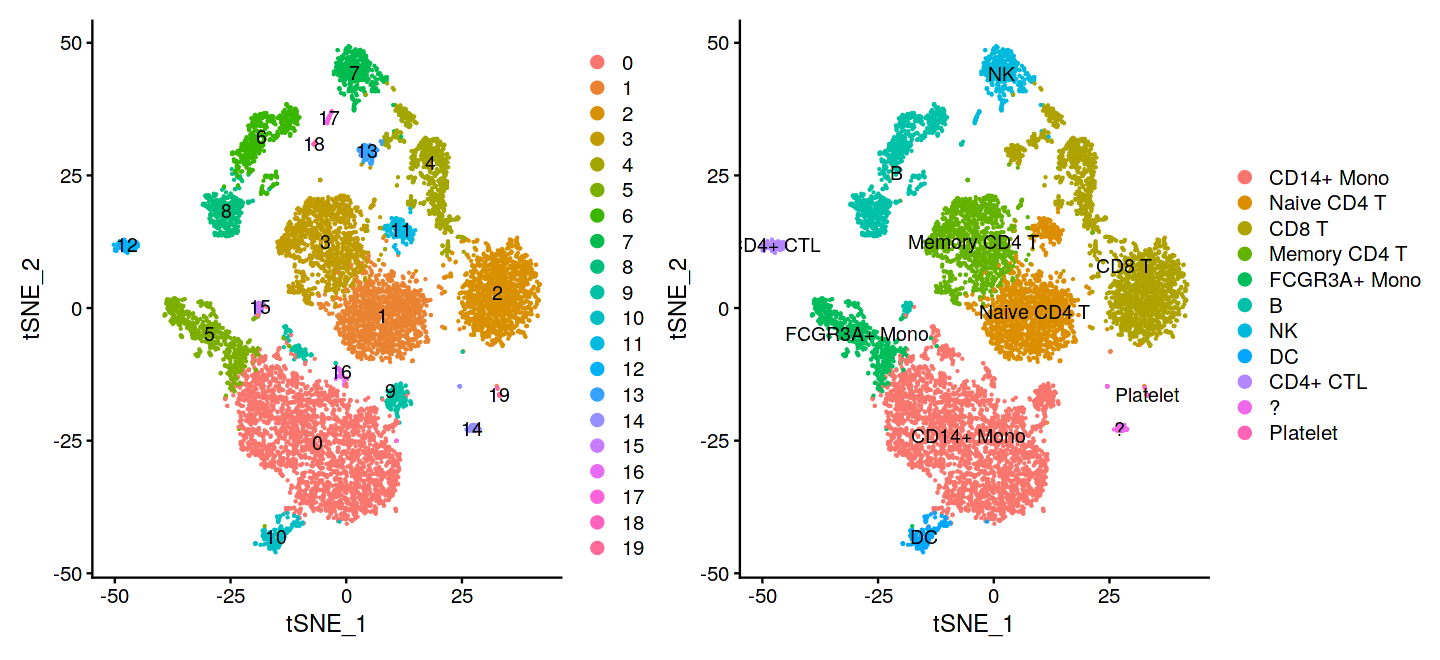

In [9]:
p0=DimPlot(scRNA, reduction = 'tsne', label = T, group.by = "seurat_clusters")
p1=DimPlot(scRNA, reduction = 'tsne', label = T)

options(repr.plot.width=12, repr.plot.height=5.5)
p0+p1 #+ plot_layout(guides = 'collect')

## 提取细胞子集

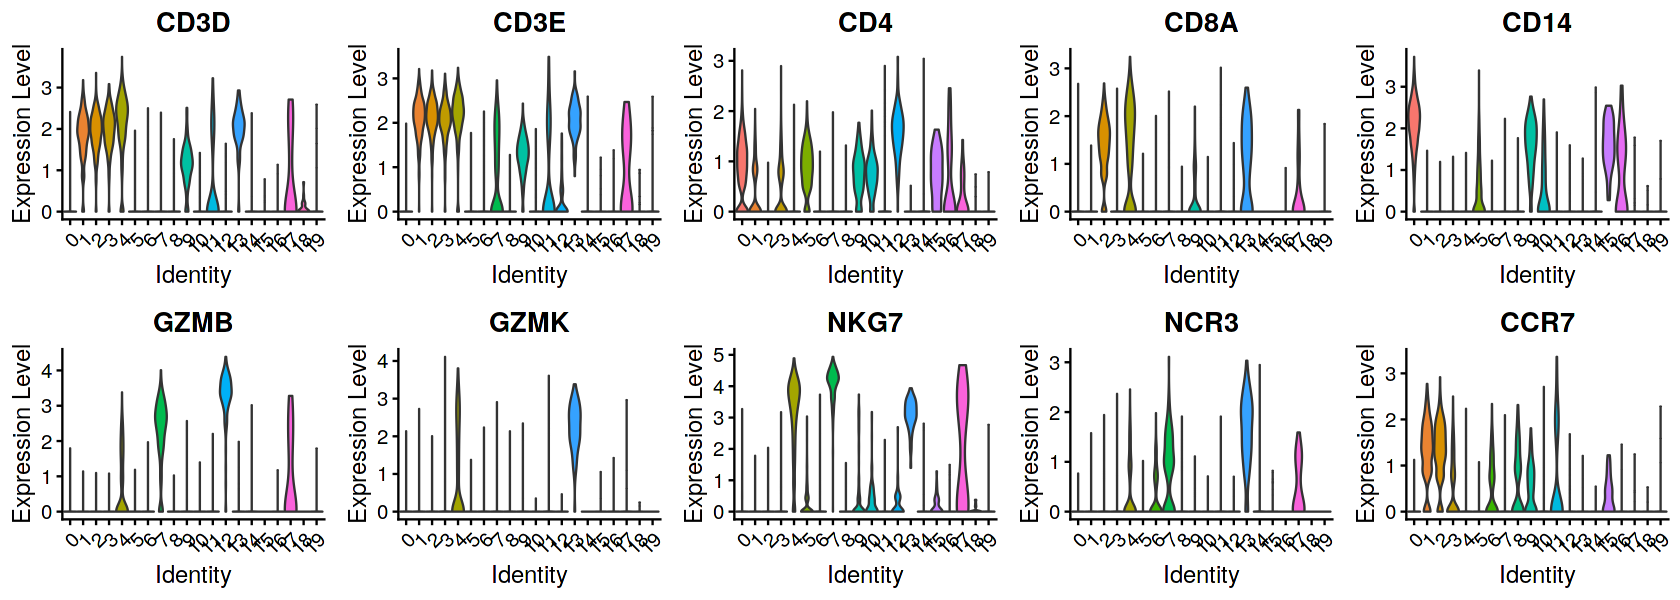

In [10]:
options(repr.plot.width=14, repr.plot.height=5)
VlnPlot(scRNA, features = c("CD3D","CD3E", "CD4", "CD8A", "CD14","GZMB", "GZMK", "NKG7","NCR3", "CCR7"), 
        ncol = 5, pt.size=0, group.by = "seurat_clusters")

- CD3D: 1,2,3,4,   9, 11, 13, 17
- CD3E: 1,2,3,4, 7,9, 11, 13, 17
- 其中 CD4+: 1,3,9, 17, 因为 c17 高表达 NCR3 为 NK，排除。
- CD8+: 2,4,13

T cell: c(1,2,3,4, 9,13)

In [11]:
Idents(scRNA)="seurat_clusters"
scRNAsub=subset(scRNA, idents = c(1,2,3,4, 9,13)) #group.by="seurat_clusters"
scRNAsub

An object of class Seurat 
22860 features across 4901 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

# PCA降维

因为再聚类的细胞之间差异比较小，所以聚类函数FindClusters()控制分辨率的参数建议调高到resolution = 0.9。

Centering and scaling data matrix

PC_ 1 
Positive:  LTB, CCR7, IL7R, IL32, RPLP1, TRBC2, MALAT1, TRBC1, NELL2, FHIT 
	   MYC, CD8B, SCGB3A1, AC013264.1, LINC02446, ADTRP, LRRN3, ID3, PASK, AQP3 
	   TRAT1, CD79A, ARMH1, SELL, CD8A, CD69, CD40LG, LRRC75A, SNHG14, CPA5 
Negative:  MNDA, CYBB, TMEM176B, FGL2, NCF2, CSTA, FCN1, SERPINA1, MS4A6A, VCAN 
	   MPEG1, IFI30, CD36, CD14, LYZ, SPI1, S100A8, CST3, TMEM176A, S100A9 
	   FPR1, S100A12, CD68, AC020656.1, CFD, SLC7A7, CLEC7A, CPVL, DUSP6, IGSF6 
PC_ 2 
Positive:  NKG7, CST7, GZMA, CCL5, GNLY, GZMH, PRF1, KLRD1, HOPX, KLRG1 
	   CCL4, B2M, FGFBP2, HLA-A, HLA-B, GZMB, TRGC2, CLIC1, PLEK, ADGRG1 
	   CD99, FCGR3A, FCRL6, C12orf75, CTSW, APOBEC3G, SH3BGRL3, EFHD2, MATK, S100A4 
Negative:  PABPC1, RPL23, CCR7, SELL, RPLP1, LTB, IL7R, FHIT, AIF1, LRRN3 
	   NELL2, ARMH1, LRRC75A, MYC, PASK, C1orf162, ADTRP, FYB1, IFNGR2, NCF1 
	   SCGB3A1, IL6R, NFKBIZ, PADI4, CFP, HRH2, TIMP2, GCA, SLC16A10, ID3 
PC_ 3 
Positive:  LTB, ITGB1, TNFRSF4, CRIP

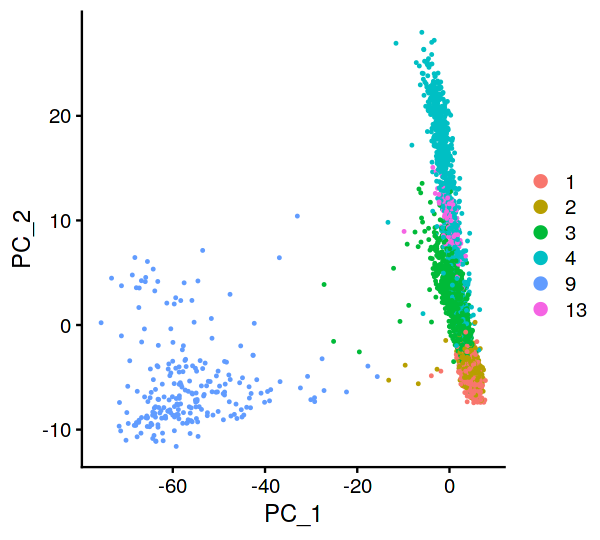

In [13]:
scRNAsub <- FindVariableFeatures(scRNAsub, selection.method = "vst", nfeatures = 2000)
scale.genes <-  rownames(scRNAsub)

scRNAsub <- ScaleData(scRNAsub, features = scale.genes)

scRNAsub <- RunPCA(scRNAsub, features = VariableFeatures(scRNAsub), npcs = 50)

options(repr.plot.width=5, repr.plot.height=4.5)
DimPlot(scRNAsub, reduction = "pca")

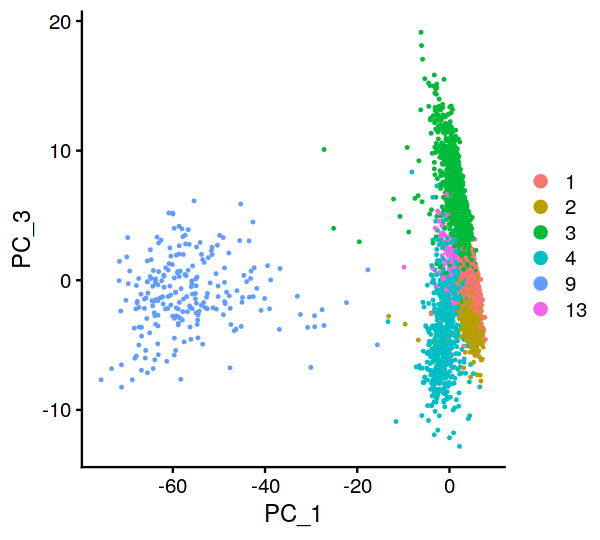

In [14]:
DimPlot(scRNAsub, reduction = "pca", dims = c(1,3))

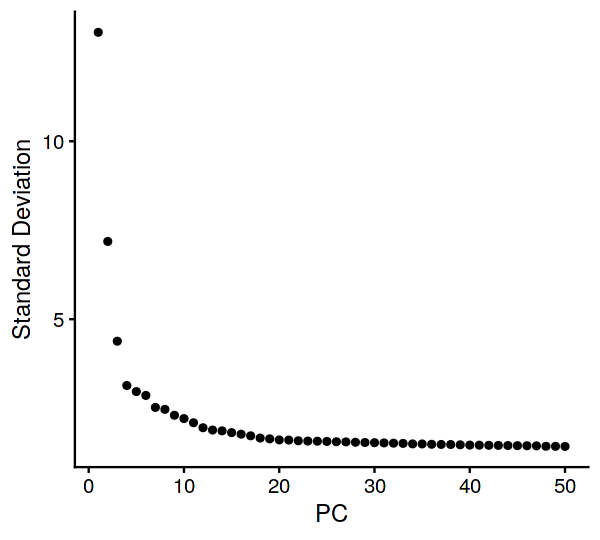

In [15]:
ElbowPlot(scRNAsub, ndims=50, reduction="pca")

In [16]:
dim(scRNAsub)

[1] 22860  4901

Warning message:
“Removed 45629 rows containing missing values (geom_point).”


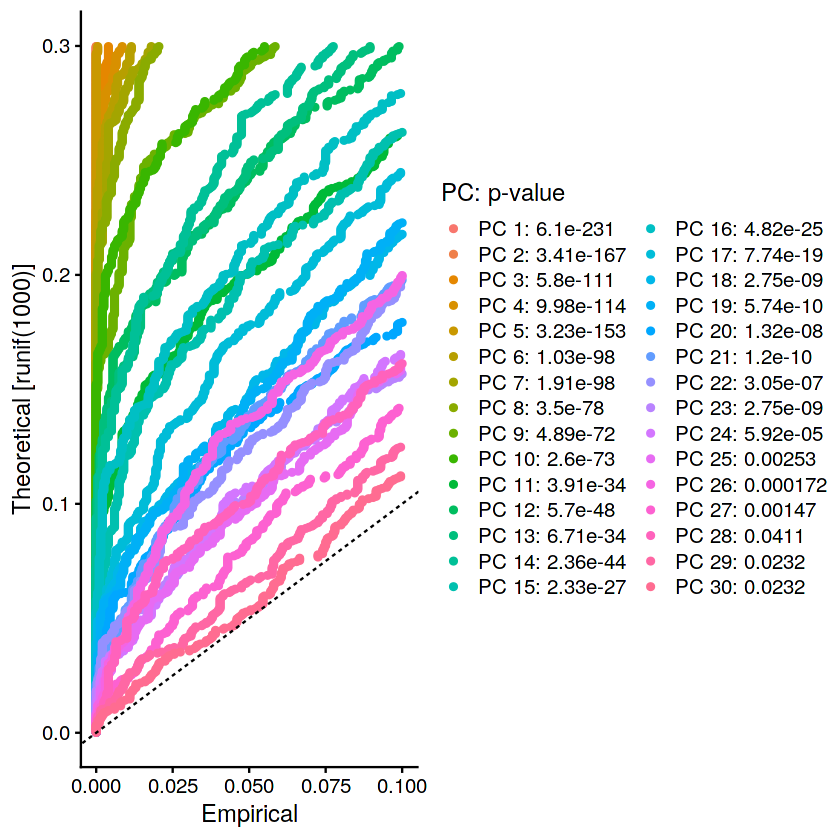

In [34]:
# option: long time: 15:30 - 
scRNAsub <- JackStraw(scRNAsub, dims = 50)
scRNAsub <- ScoreJackStraw(scRNAsub, dims = 1:50)
JackStrawPlot(scRNAsub, dims = 1:30)

## 细胞聚类

In [26]:
pc.num=1:20

##细胞聚类
scRNAsub <- FindNeighbors(scRNAsub, dims = pc.num) 
scRNAsub <- FindClusters(scRNAsub, resolution = 1.0) ### 高分辨率
table(scRNAsub@meta.data$seurat_clusters)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4901
Number of edges: 183334

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7977
Number of communities: 14
Elapsed time: 0 seconds



   0    1    2    3    4    5    6    7    8    9   10   11   12   13 
1052  829  505  502  346  306  305  238  233  197  173   94   82   39 

In [27]:
# 也可以直接保存 meta.data
metadata <- scRNAsub@meta.data
cell_cluster <- data.frame(
    cell_ID=rownames(metadata), 
    cluster_ID=metadata$seurat_clusters
)

head(cell_cluster)
write.csv(cell_cluster, paste0(outputRoot, '00_cell_cluster.csv'), row.names = F)

cell_ID          cluster_ID
1 AAACCCAGTCGGTGAA 10        
2 AAACCCAGTTTCCCAC 7         
3 AAACCCATCAGACAAA 0         
4 AAACCCATCCATACTT 6         
5 AAACGAACAACTCGAT 9         
6 AAACGAACACCGAATT 2

### 质控

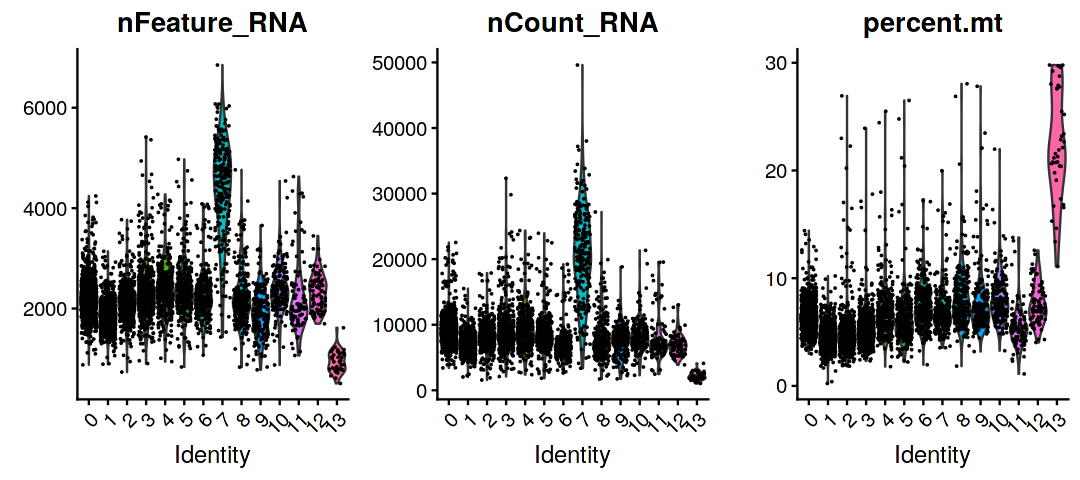

In [32]:
violin=VlnPlot(scRNAsub,
        features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), 
        #cols =rainbow(20), 
        pt.size = 0.01, #不需要显示点，可以设置pt.size = 0
        ncol = 3) + 
        theme(axis.title.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank()) 

options(repr.plot.width=9, repr.plot.height=4)
violin

ggsave(paste0(outputRoot,"00_QC_violin.pdf"), plot = violin, width = 9, height = 4)

In [35]:
# c13 gene和 counts低，mt高，应该是破碎的细胞，可以整体删去。
# c7 基因高表达，更像是 NK 或者 NKT

scRNAsub2=subset(scRNAsub, idents = c(7, 13), invert=T) #invert 反向选取
scRNAsub2
scRNAsub2@meta.data$seurat_clusters = factor( as.character( scRNAsub2@meta.data$seurat_clusters ), 
                                         levels=c(0:6,8:12),
                                         labels=0:11 )# 重新编号
table(scRNAsub2@meta.data$seurat_clusters)

An object of class Seurat 
22860 features across 4624 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne


   0    1    2    3    4    5    6    7    8    9   10   11 
1052  829  505  502  346  306  305  233  197  173   94   82 

### 重新细胞聚类

In [36]:
table(scRNAsub2@active.ident)


   0    1    2    3    4    5    6    8    9   10   11   12 
1052  829  505  502  346  306  305  233  197  173   94   82 

In [37]:
##细胞聚类
scRNAsub <- FindNeighbors(scRNAsub2, dims = pc.num) 
scRNAsub <- FindClusters(scRNAsub, resolution = 1.0) ### 高分辨率
table(scRNAsub@meta.data$seurat_clusters)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4624
Number of edges: 174394

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7793
Number of communities: 12
Elapsed time: 0 seconds



   0    1    2    3    4    5    6    7    8    9   10   11 
1052  784  544  501  347  304  304  233  196  174  103   82 

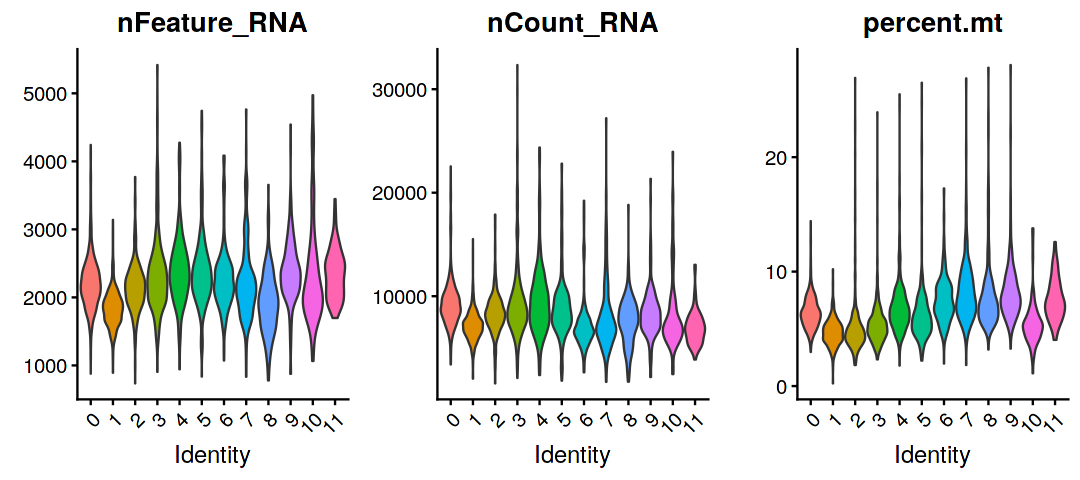

In [39]:
VlnPlot(scRNAsub, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), pt.size=0 )

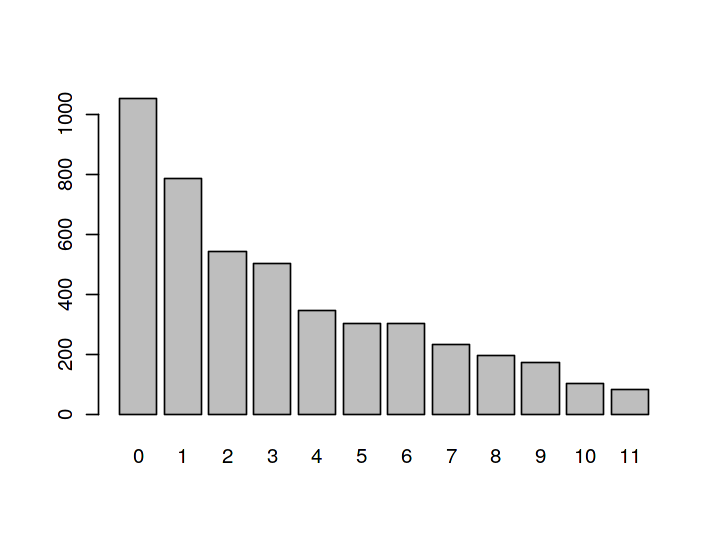

In [48]:
options(repr.plot.width=6, repr.plot.height=4.5)
barplot(table(scRNAsub@meta.data$seurat_clusters))

## 非线性降维

### tSNE

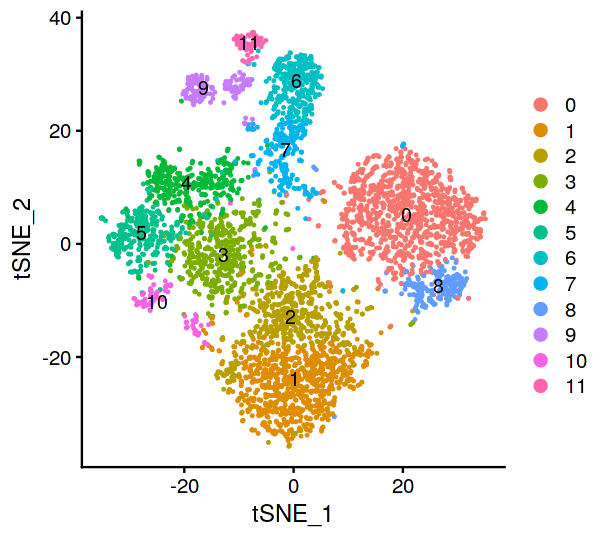

In [43]:
#tSNE
set.seed(20210219)
scRNAsub = RunTSNE(scRNAsub, dims = pc.num)
embed_tsne <- Embeddings(scRNAsub, 'tsne')
write.csv(embed_tsne, paste0(outputRoot,'01_subcluster_embed_tsne.csv') )

plot1 = DimPlot(scRNAsub, reduction = "tsne",label = TRUE)

options(repr.plot.width=5, repr.plot.height=4.5)
print(plot1)
ggsave(paste0(outputRoot,"01_subcluster_embed_tSNE.pdf"), plot = plot1, width = 8, height = 7)
#ggsave(paste0(outputRoot,"01_subcluster_tSNE.png"), plot = plot1, width = 8, height = 7)

### UMAP

In [44]:
#UMAP
set.seed(20210219)
scRNAsub <- RunUMAP(scRNAsub, dims = pc.num)
embed_umap <- Embeddings(scRNAsub, 'umap')
write.csv(embed_umap,paste0(outputRoot,'01_subcluster_embed_umap.csv') ) 

11:34:30 UMAP embedding parameters a = 0.9922 b = 1.112

11:34:30 Read 4624 rows and found 20 numeric columns

11:34:30 Using Annoy for neighbor search, n_neighbors = 30

11:34:30 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:34:31 Writing NN index file to temp file /tmp/RtmpiwvFHM/file33a064fc8564

11:34:31 Searching Annoy index using 1 thread, search_k = 3000

11:34:32 Annoy recall = 100%

11:34:32 Commencing smooth kNN distance calibration using 1 thread

11:34:32 Initializing from normalized Laplacian + noise

11:34:32 Commencing optimization for 500 epochs, with 195138 positive edges

11:34:37 Optimization finished



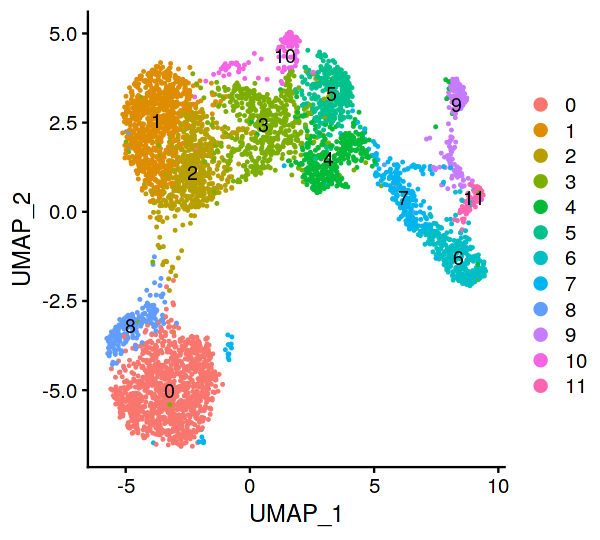

In [45]:
plot2 = DimPlot(scRNAsub, reduction = "umap",label = TRUE) 

options(repr.plot.width=5, repr.plot.height=4.5)
print(plot2)
ggsave( paste0(outputRoot,"01_subcluster_UMAP.pdf"), plot = plot2, width = 8, height = 7)
#ggsave( paste0(outputRoot,"01_subcluster_UMAP.png"), plot = plot2, width = 8, height = 7)

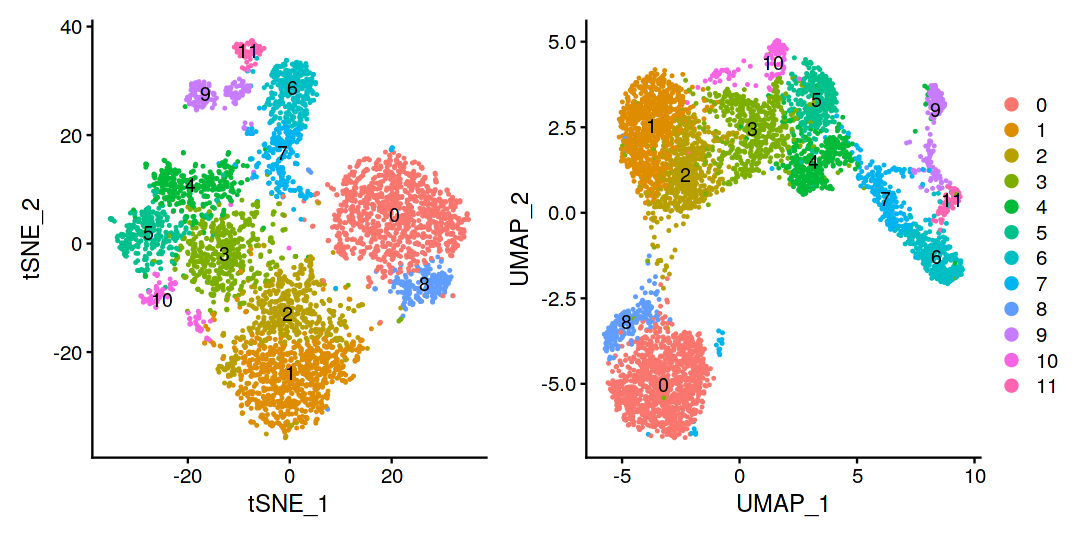

In [46]:
#合并tSNE与UMAP
plotc <- plot1+plot2+ plot_layout(guides = 'collect')

options(repr.plot.width=9, repr.plot.height=4.5)
plotc

ggsave( paste0(outputRoot,"01_subcluster_tSNE_UMAP.pdf"), plot = plotc, width = 10, height = 5)

# Cluster间差异基因

In [47]:
diff.wilcox = FindAllMarkers(scRNAsub) # about 5min;
all.markers = diff.wilcox %>% select(gene, everything()) %>% subset(p_val<0.05)

top10 = all.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
write.csv(all.markers, paste0(outputRoot,"02_subcluster_diff_genes_wilcox.csv"), row.names = F)
write.csv(top10, paste0(outputRoot,"02_subcluster_top10_diff_genes_wilcox.csv"), row.names = F)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



## heatmap of cluster

png 
  2

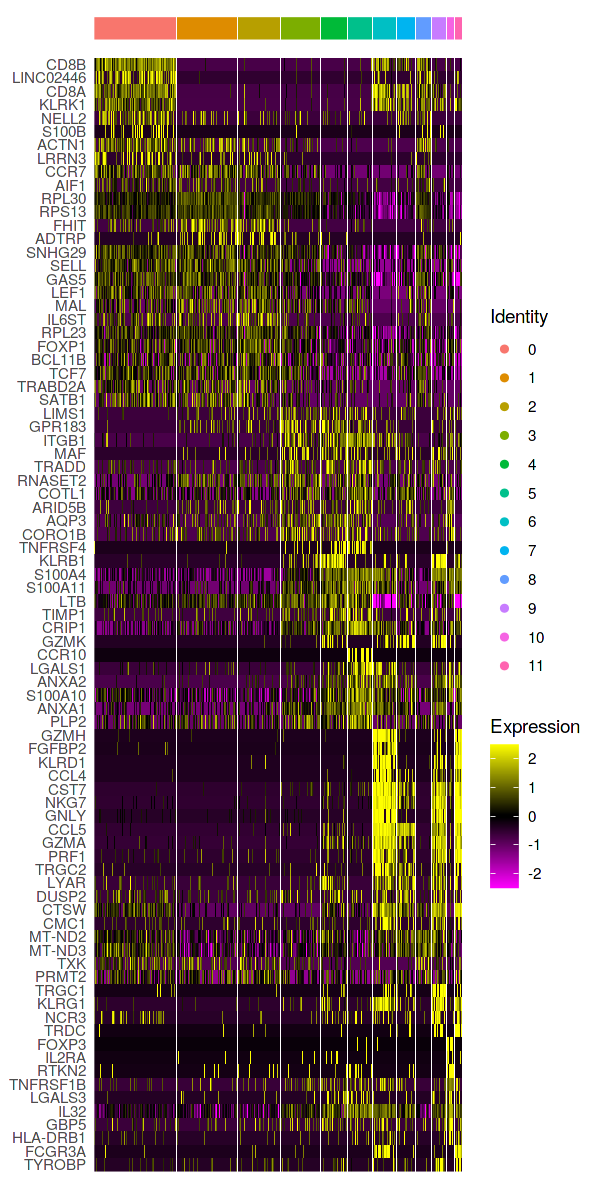

In [49]:
p1=DoHeatmap(scRNAsub, features = top10$gene, label = F )  #+ NoLegend()

options(repr.plot.width=5, repr.plot.height=10)
print(p1)

pdf( paste0(outputRoot, "02_plot_DoHeatmap.pdf"), width=8, height=10)
print(p1)
dev.off()

png 
  2

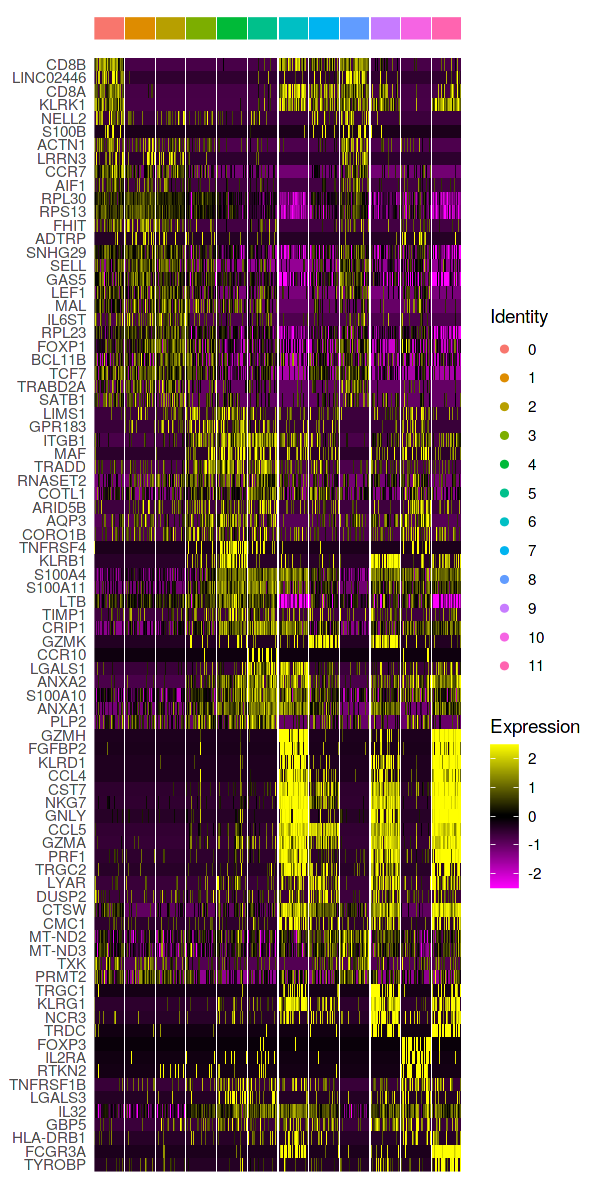

In [52]:
# heatmap small
set.seed(20210219)
p2=DoHeatmap( subset(scRNAsub, downsample=50 ), features = top10$gene, label = F )  #+ NoLegend()

options(repr.plot.width=5, repr.plot.height=10)
p2

pdf( paste0(outputRoot, "01_subT_plot_DoHeatmap_downsample.pdf"), width=5, height=10)
print(p2)
dev.off()
# 1==2; 3==4==5; 6==9==11, 

In [50]:
top5 <- all.markers  %>% group_by(cluster) %>% top_n(n = 5, wt = avg_logFC)
dim(top5)

[1] 60  7

png 
  2

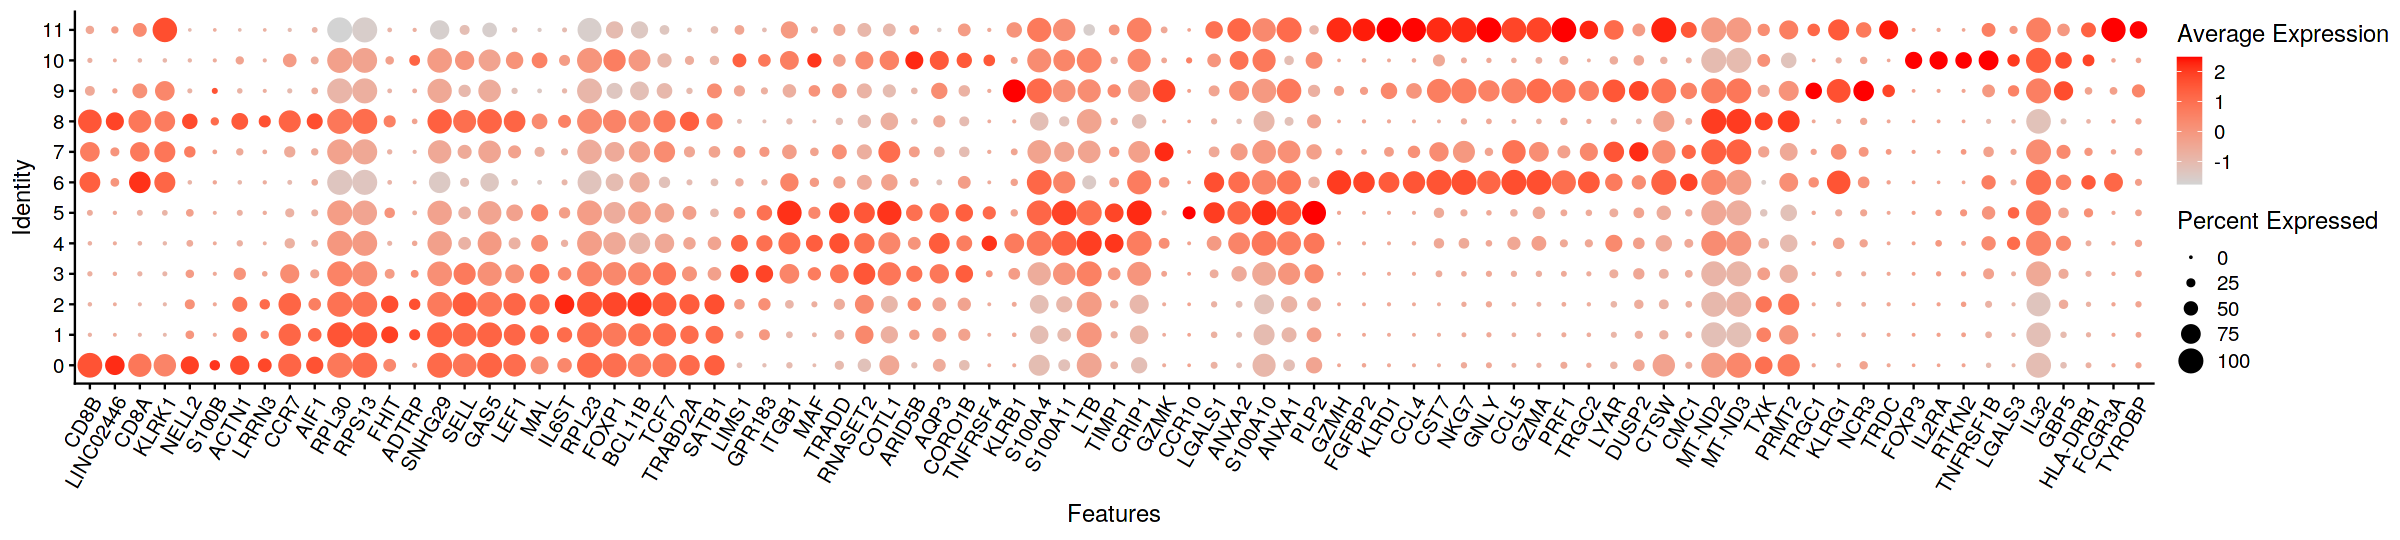

In [54]:
library(ggplot2)
p1=DotPlot(scRNAsub, features = rev(unique( top10$gene )), cols = c("lightgrey", "red") ) +
 theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

options(repr.plot.width=20, repr.plot.height=4.5)
print(p1)

pdf( paste0(outputRoot, "02_plot_DotPlot.pdf"), width=20, height=4.5)
print(p1)
dev.off()

### search gene names

In [55]:
searchGene=function(pattern="^CCN"){
    rownames( scRNAsub@assays$RNA)[ grep(pattern, rownames( scRNAsub@assays$RNA) ) ]
}
# test
searchGene()

[1] "CCNL2"     "CCNT2-AS1" "CCNT2"     "CCNYL1"    "CCNL1"     "CCNI"     
 [7] "CCNG2"     "CCNA2"     "CCNB1"     "CCNH"      "CCNI2"     "CCNJL"    
[13] "CCNG1"     "CCND3"     "CCNC"      "CCN6"      "CCN2"      "CCNE2"    
[19] "CCN3"      "CCNY"      "CCNJ"      "CCND1"     "CCND2-AS1" "CCND2"    
[25] "CCNT1"     "CCNB1IP1"  "CCNK"      "CCNDBP1"   "CCNB2"     "CCNF"     
[31] "CCNE1"     "CCN5"      "CCNB3"     "CCNQ"

png 
  2

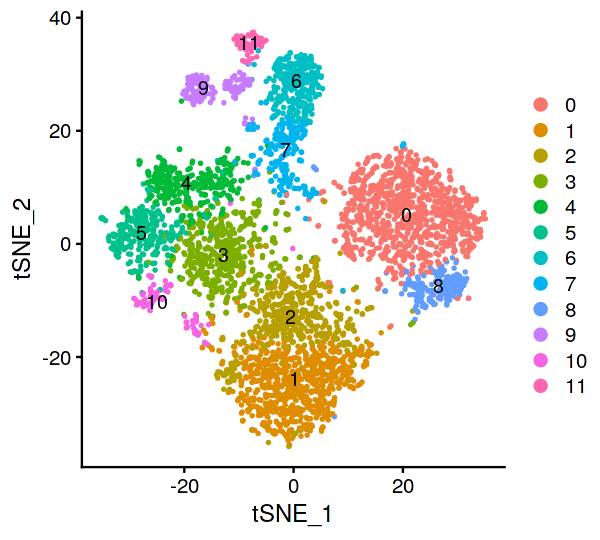

In [57]:
p1=DimPlot(scRNAsub, reduction = "tsne", label = TRUE, pt.size = 0.5) #+ NoLegend()

options(repr.plot.width=5, repr.plot.height=4.5)
print(p1)

pdf( paste0(outputRoot, "03_plot_tSNE.pdf"), width=4.5, height=4)
print(p1)
dev.off()

## markers

### CD4 and CD8

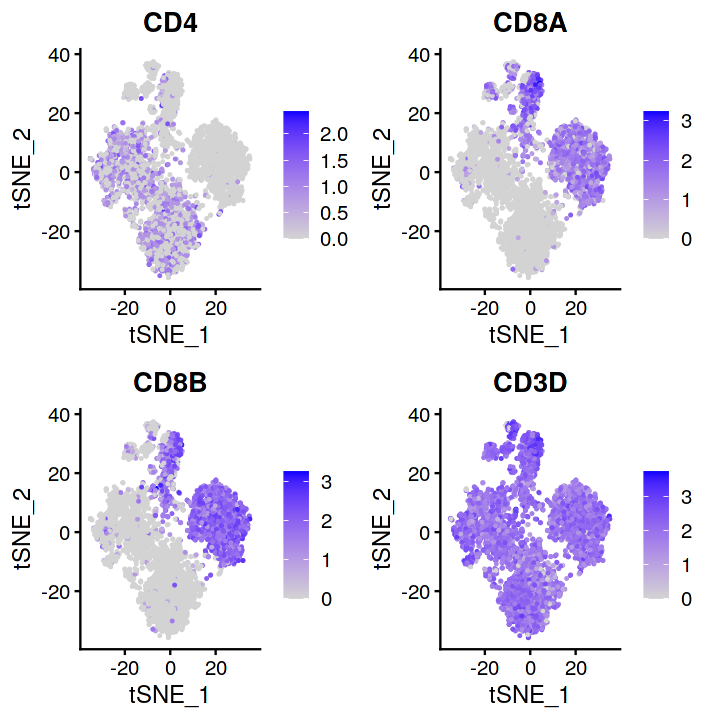

In [59]:
options(repr.plot.width=6, repr.plot.height=6)
FeaturePlot(scRNAsub, features = c("CD4", "CD8A", "CD8B","CD3D"), reduction = "tsne")

* CD8: 0,8,  4,7,  9? 
* CD4: 1,2, 3,5,6, 10

In [60]:
searchGene("IFN")

[1] "IFNLR1"   "IFNGR1"   "IFNG-AS1" "IFNG"     "IFNL1"    "IFNAR2"   "IFNAR1"  
[8] "IFNGR2"

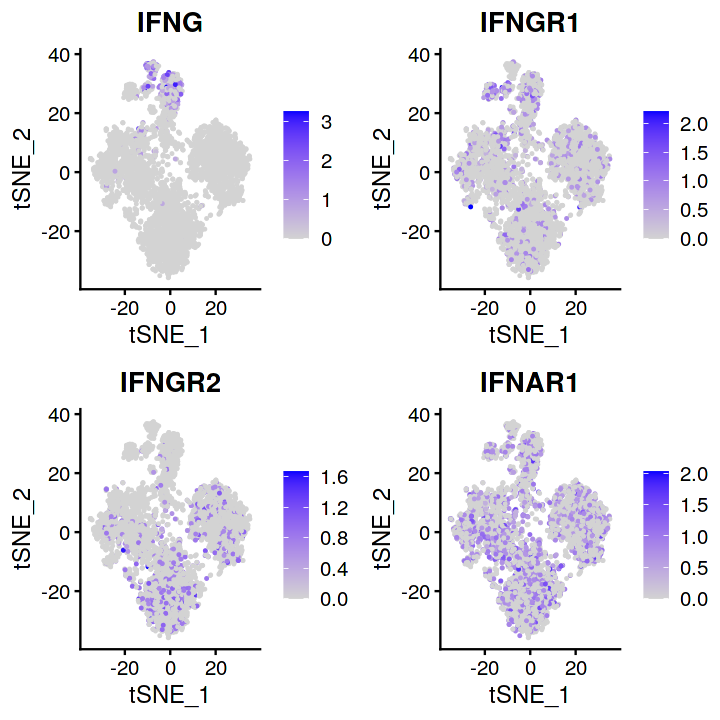

In [61]:
FeaturePlot(scRNAsub, features = c("IFNG", "IFNGR1", "IFNGR2","IFNAR1"), reduction = "tsne")

### GZM-

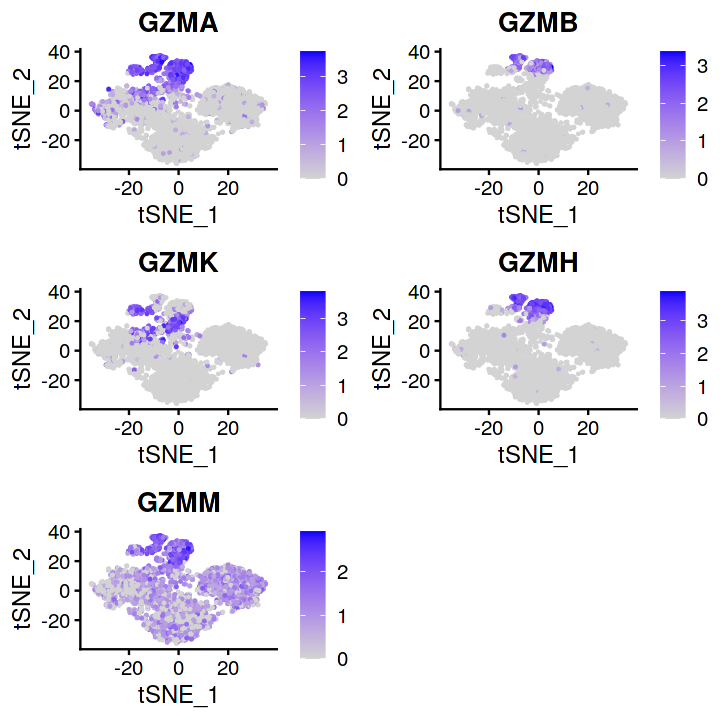

In [62]:
FeaturePlot(scRNAsub, features = c("GZMA","GZMB", "GZMK","GZMH", "GZMM"), reduction = "tsne")

### T reg

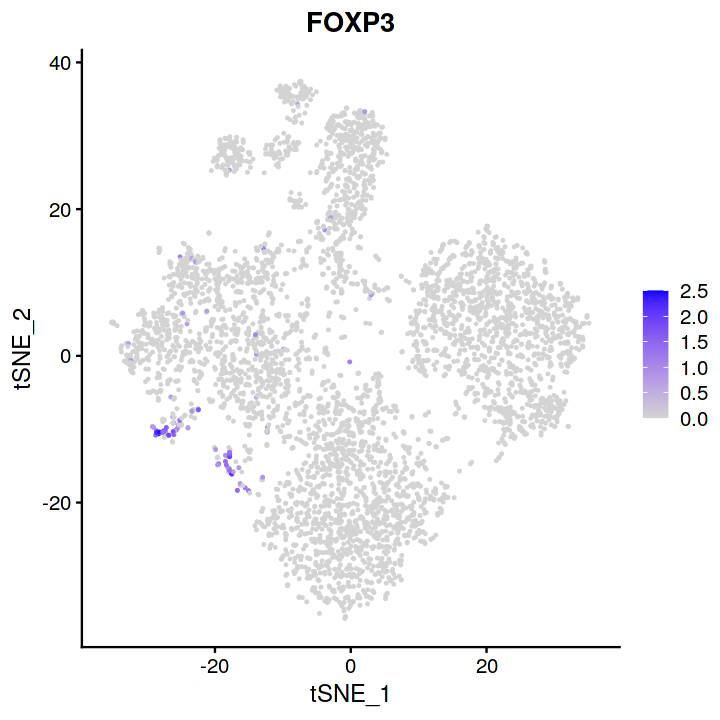

In [63]:
FeaturePlot(scRNAsub, features = c("FOXP3"), reduction = "tsne")
# 11

### cell cycle (no use)

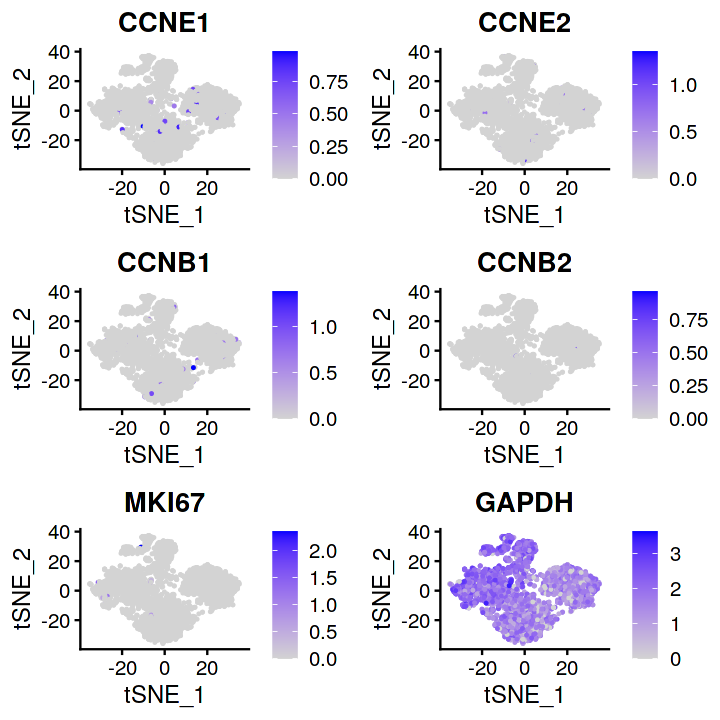

In [64]:
FeaturePlot(scRNAsub, features = c("CCNE1","CCNE2","CCNB1","CCNB2", "MKI67", 'GAPDH'), reduction = "tsne")

### IL-d (no use)

In [65]:
searchGene("^TNFA")

[1] "TNFAIP8L2" "TNFAIP6"   "TNFAIP8"   "TNFAIP3"   "TNFAIP2"   "TNFAIP8L3"
[7] "TNFAIP1"   "TNFAIP8L1"

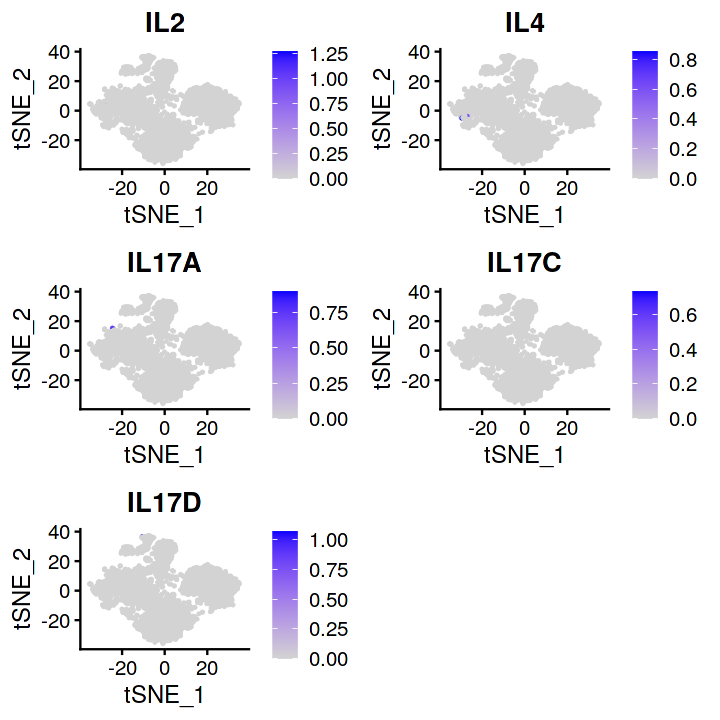

In [66]:
FeaturePlot(scRNAsub, features = c("IL2","IL4","IL17A","IL17C", 'IL17D'), reduction = "tsne")

### CCR7(naive marker)

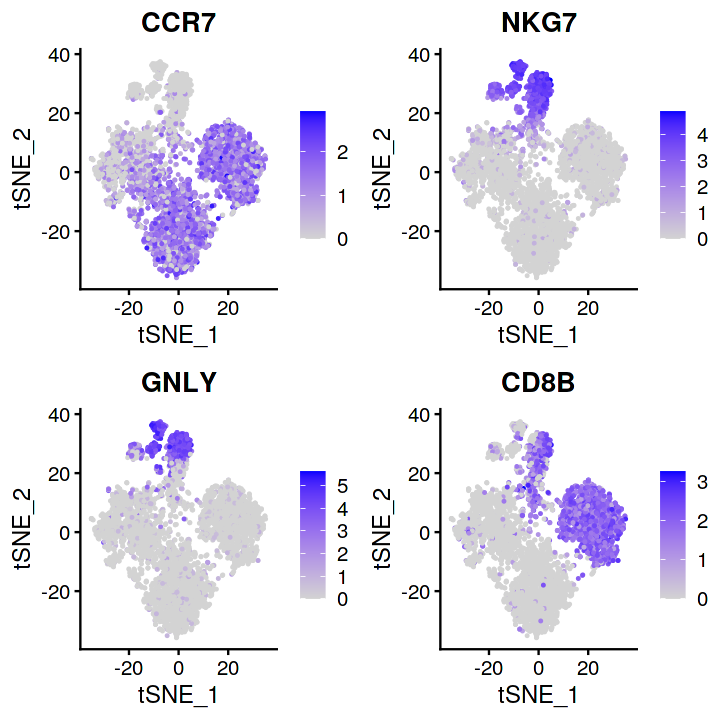

In [67]:
FeaturePlot(scRNAsub, features = c("CCR7", "NKG7", "GNLY", 'CD8B'), reduction = "tsne")

* no GNLY in 7

### CCL4 (todo)

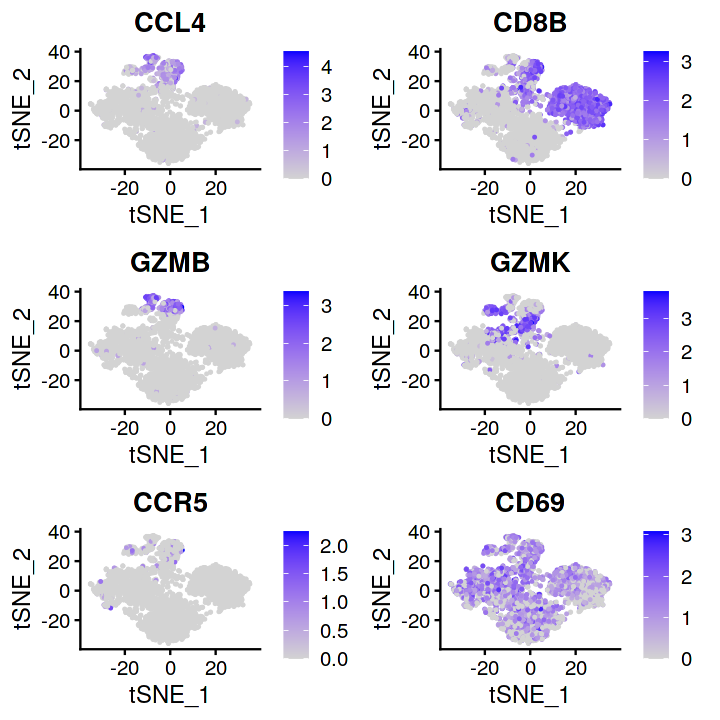

In [68]:
FeaturePlot(scRNAsub, features = c("CCL4", 'CD8B', 'GZMB','GZMK', "CCR5",'CD69'), reduction = "tsne")

In [69]:
searchGene("^CCL5")

[1] "CCL5"

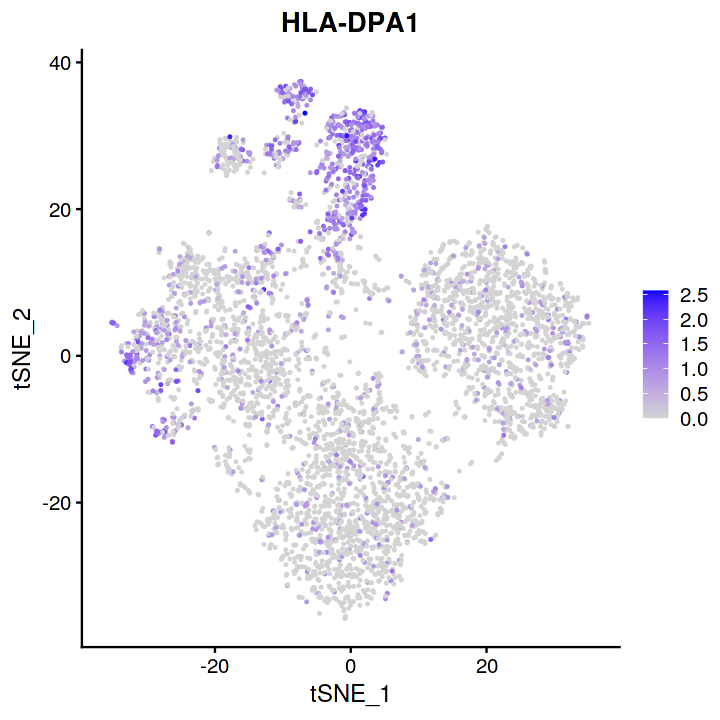

In [70]:
FeaturePlot(scRNAsub, features = c("HLA-DPA1"), reduction = "tsne")

### Th17 cell

* https://www.rndsystems.com/cn/resources/cell-markers/immune-cells/helper-t-cells/th17-cell-markers

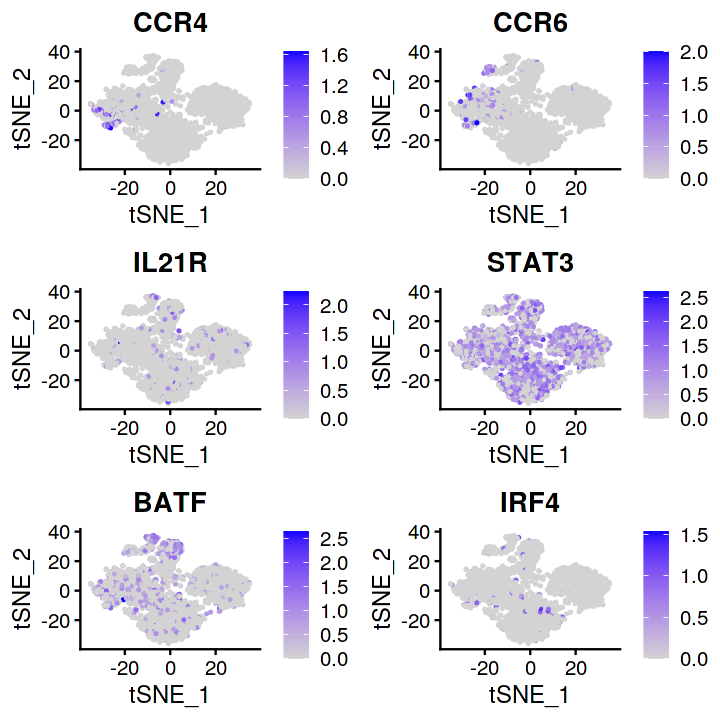

In [71]:
FeaturePlot(scRNAsub, features = c("CCR4","CCR6", "IL21R", "STAT3",'BATF','IRF4'), reduction = "tsne")

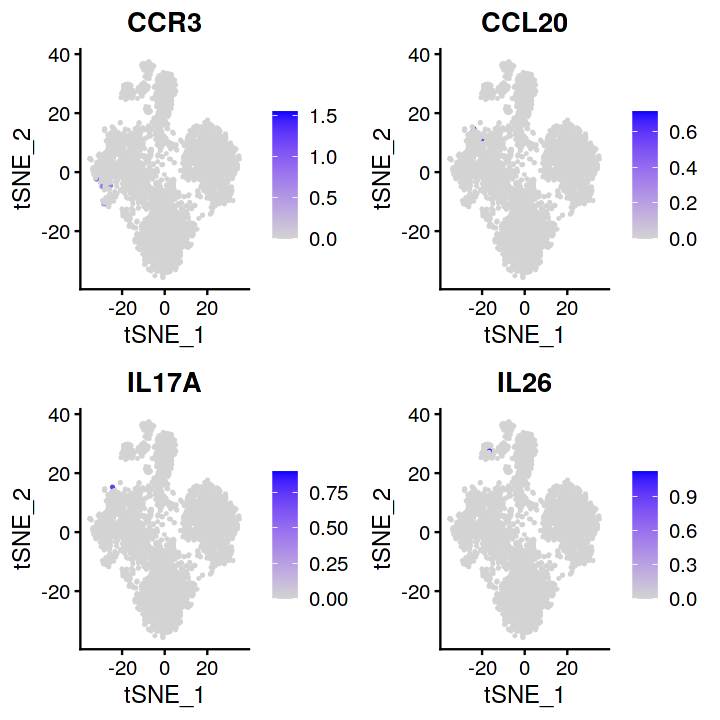

In [72]:
FeaturePlot(scRNAsub, features = c("CCR3","CCL20","IL17A","IL26"), reduction = "tsne")

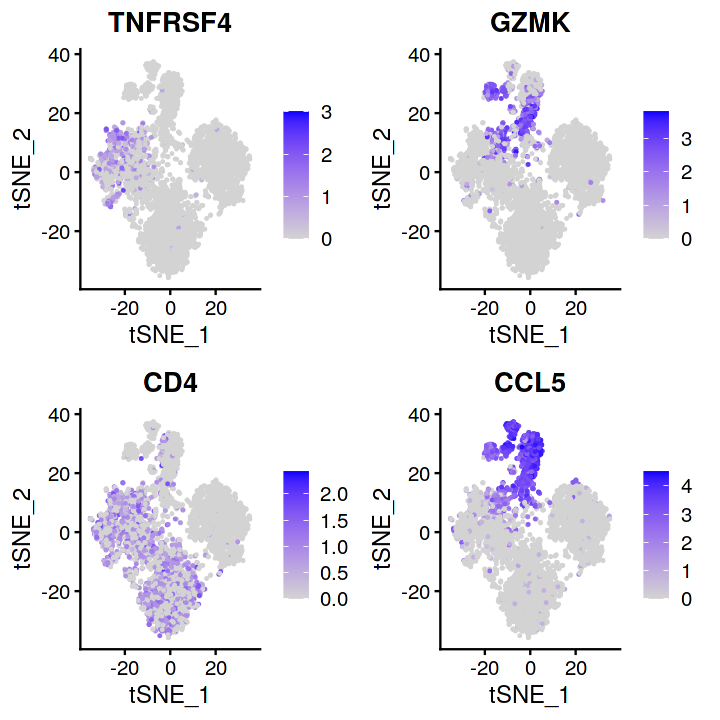

In [73]:
FeaturePlot(scRNAsub, features = c("TNFRSF4", "GZMK", 'CD4','CCL5'), reduction = "tsne") #5

## 两两比较

大的分类有了之后，两两比较找更细微的marker

### 0 vs 8

In [100]:
findSigMarker=function(ident1=0, ident2=9, logFC_threshold=1 ){
    cat("cluster:",ident1, ident2, "\n")
    markers.2=FindMarkers(scRNAsub, ident.1=ident1, ident.2 =ident2 )
    top10.2 = markers.2 %>% filter(p_val_adj<0.05 & abs(avg_logFC) > logFC_threshold ) 
        #top_n(n = 10, wt = avg_logFC)
    print(dim(top10.2))
    print(head(top10.2))
    top10.2
}
findSigMarker(0,8,0.9)

cluster: 0 8 
[1] 5 5
             p_val avg_logFC pct.1 pct.2    p_val_adj
JUN   2.056498e-97  2.114080 0.986 0.372 4.701155e-93
JUNB  2.009834e-91  1.815037 0.990 0.648 4.594481e-87
FOS   2.127453e-86  1.744735 0.969 0.337 4.863357e-82
FOSB  4.994184e-84  1.472352 0.933 0.194 1.141671e-79
DUSP1 8.060609e-64  1.162331 0.885 0.281 1.842655e-59


p_val        avg_logFC pct.1 pct.2 p_val_adj   
JUN   2.056498e-97 2.114080  0.986 0.372 4.701155e-93
JUNB  2.009834e-91 1.815037  0.990 0.648 4.594481e-87
FOS   2.127453e-86 1.744735  0.969 0.337 4.863357e-82
FOSB  4.994184e-84 1.472352  0.933 0.194 1.141671e-79
DUSP1 8.060609e-64 1.162331  0.885 0.281 1.842655e-59

### 1 vs 2

In [106]:
# 1 vs 2
findSigMarker(1,2,0.4)

cluster: 1 2 
[1] 5 5
             p_val  avg_logFC pct.1 pct.2    p_val_adj
FOSB  2.465300e-32 -0.4922185 0.705 0.917 5.635676e-28
DDX3X 1.286578e-29 -0.4274737 0.704 0.882 2.941118e-25
XIST  5.741720e-29 -0.4023408 0.668 0.897 1.312557e-24
NEAT1 8.971552e-27 -0.4748126 0.717 0.904 2.050897e-22
JUN   9.707336e-21 -0.4033997 0.864 0.952 2.219097e-16


p_val        avg_logFC  pct.1 pct.2 p_val_adj   
FOSB  2.465300e-32 -0.4922185 0.705 0.917 5.635676e-28
DDX3X 1.286578e-29 -0.4274737 0.704 0.882 2.941118e-25
XIST  5.741720e-29 -0.4023408 0.668 0.897 1.312557e-24
NEAT1 8.971552e-27 -0.4748126 0.717 0.904 2.050897e-22
JUN   9.707336e-21 -0.4033997 0.864 0.952 2.219097e-16

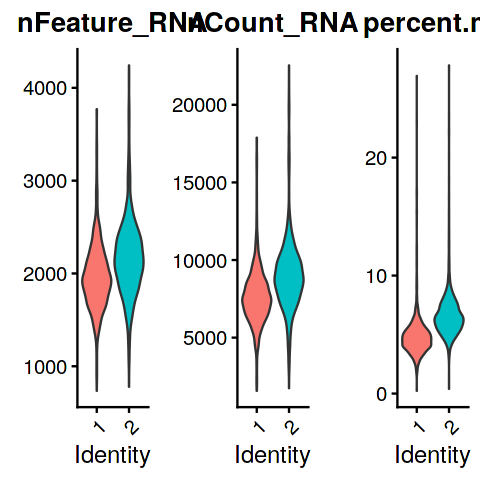

In [109]:
# c2 has more gene, counts than c1.
options(repr.plot.width=4, repr.plot.height=4)
VlnPlot(scRNA, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), pt.size = 0, idents = c(1,2))

### c(1,2) vs 3

In [175]:
# 1,2 vs 3
rs2_3=findSigMarker( c(1,2), 3, 0.7)
rs2_3

cluster: 1 2 3 
[1] 7 5
                p_val  avg_logFC pct.1 pct.2     p_val_adj
ITGB1   2.655792e-135 -1.0923274 0.181 0.750 6.071140e-131
S100A4   5.832262e-83 -0.9864803 0.698 0.916  1.333255e-78
S100A11  6.898926e-80 -0.7377095 0.515 0.878  1.577095e-75
KLRB1    1.638343e-75 -0.8938069 0.048 0.375  3.745252e-71
CRIP1    1.994585e-75 -0.7454695 0.708 0.948  4.559622e-71
KLF6     6.429123e-71 -0.7741113 0.531 0.878  1.469698e-66


p_val         avg_logFC  pct.1 pct.2 p_val_adj    
ITGB1   2.655792e-135 -1.0923274 0.181 0.750 6.071140e-131
S100A4   5.832262e-83 -0.9864803 0.698 0.916  1.333255e-78
S100A11  6.898926e-80 -0.7377095 0.515 0.878  1.577095e-75
KLRB1    1.638343e-75 -0.8938069 0.048 0.375  3.745252e-71
CRIP1    1.994585e-75 -0.7454695 0.708 0.948  4.559622e-71
KLF6     6.429123e-71 -0.7741113 0.531 0.878  1.469698e-66
ANXA1    4.008059e-62 -0.7113913 0.556 0.864  9.162423e-58

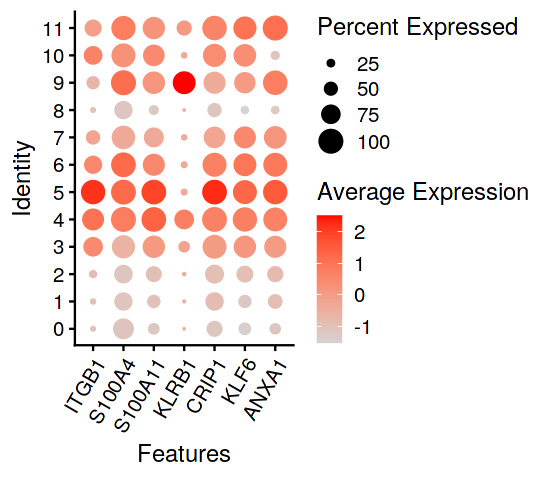

In [189]:
options(repr.plot.width=4.5, repr.plot.height=4)
DotPlot(scRNAsub, features = rev( rownames(rs2_3) ), cols = c("lightgrey", "red") ) +
 theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

### 6 vs 7

In [113]:
# 6 vs 7
rs6=findSigMarker( 6, 7, 0.8)
dim(rs6)

cluster: 6 7 
[1] 24  5
              p_val avg_logFC pct.1 pct.2    p_val_adj
GZMH   1.603630e-81  2.361706 0.964 0.155 3.665899e-77
NKG7   2.752555e-74  1.366629 1.000 0.858 6.292341e-70
GNLY   1.494393e-67  2.385487 0.924 0.219 3.416182e-63
FGFBP2 7.326152e-64  1.907104 0.836 0.094 1.674758e-59
IL7R   2.174379e-58 -1.527809 0.306 0.901 4.970629e-54
EFHD2  4.016780e-55  1.166136 0.911 0.339 9.182359e-51


[1] 24  5

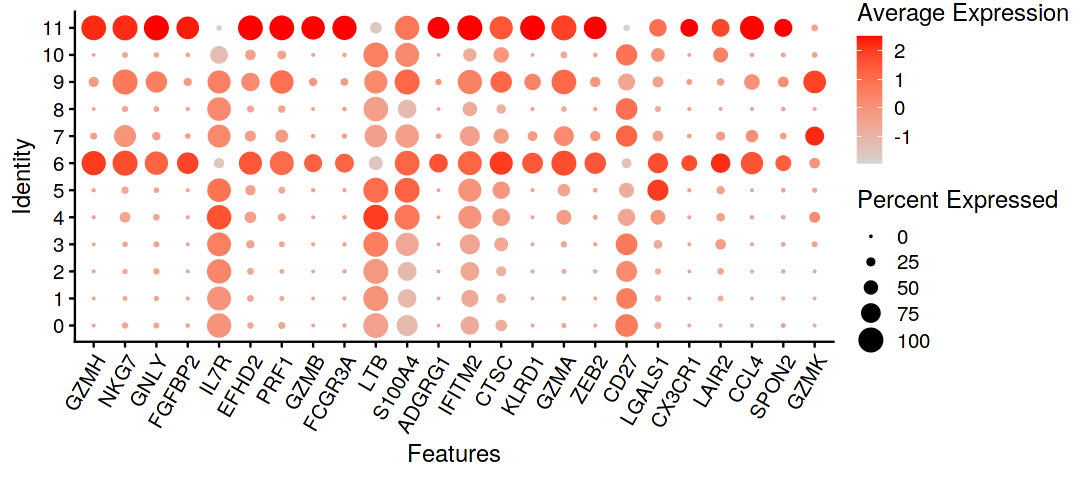

In [115]:
# 6 vs 7
options(repr.plot.width=9, repr.plot.height=4)

DotPlot(scRNAsub, features = rev(unique( rownames(rs6) )), cols = c("lightgrey", "red") ) +
 theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

### 6 v s11

In [118]:
# 6 vs 11
rs6_11=findSigMarker( 6, 11, 0.8)
rs6_11

cluster: 6 11 
[1] 7 5
              p_val avg_logFC pct.1 pct.2    p_val_adj
KLRC3  6.203645e-49 -1.297527 0.043 0.744 1.418153e-44
TRDC   6.565988e-47 -1.787651 0.030 0.720 1.500985e-42
KLRC2  3.736404e-37 -1.279111 0.102 0.756 8.541419e-33
TYROBP 7.606528e-25 -1.863804 0.158 0.646 1.738852e-20
KLRF1  5.707763e-21 -1.087054 0.359 0.817 1.304795e-16
CD8B   8.376461e-21  1.294081 0.803 0.220 1.914859e-16


p_val        avg_logFC  pct.1 pct.2 p_val_adj   
KLRC3  6.203645e-49 -1.2975265 0.043 0.744 1.418153e-44
TRDC   6.565988e-47 -1.7876507 0.030 0.720 1.500985e-42
KLRC2  3.736404e-37 -1.2791106 0.102 0.756 8.541419e-33
TYROBP 7.606528e-25 -1.8638037 0.158 0.646 1.738852e-20
KLRF1  5.707763e-21 -1.0870545 0.359 0.817 1.304795e-16
CD8B   8.376461e-21  1.2940814 0.803 0.220 1.914859e-16
KLRC1  7.710784e-10 -0.9272633 0.033 0.232 1.762685e-05

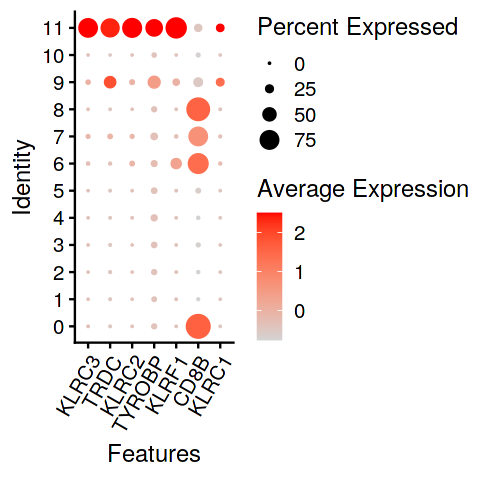

In [120]:
# 6 vs 11
options(repr.plot.width=4, repr.plot.height=4)

DotPlot(scRNAsub, features = rev(unique( rownames(rs6_11) )), cols = c("lightgrey", "red") ) +
 theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

### 9 vs 11

In [122]:
rs9_11=findSigMarker( 9, 11, 0.8)
dim(rs9_11)

cluster: 9 11 
[1] 34  5
              p_val avg_logFC pct.1 pct.2    p_val_adj
FCGR3A 3.170433e-39 -1.694327 0.190 0.963 7.247610e-35
GZMH   1.387777e-37 -1.989373 0.299 0.988 3.172458e-33
ADGRG1 2.374365e-32 -1.140166 0.121 0.854 5.427799e-28
IL7R   4.994933e-32  2.338260 0.908 0.085 1.141842e-27
GZMB   1.745906e-31 -1.460848 0.207 0.927 3.991142e-27
FGFBP2 1.459922e-29 -1.621653 0.207 0.890 3.337383e-25


[1] 34  5

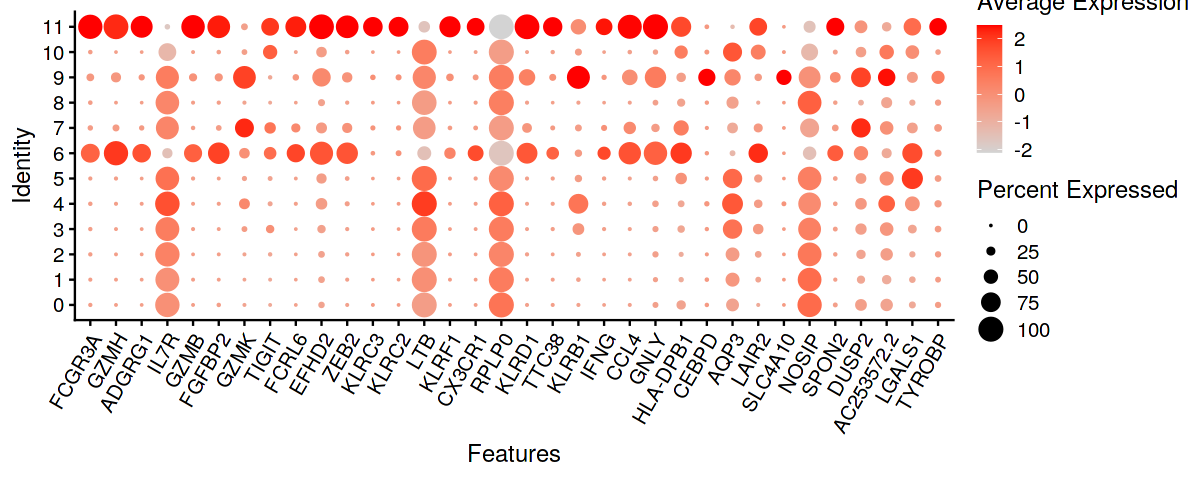

In [124]:
options(repr.plot.width=10, repr.plot.height=4)

DotPlot(scRNAsub, features = rev(unique( rownames(rs9_11) )), cols = c("lightgrey", "red") ) +
 theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

### 7 vs 9

In [125]:
rs7_9=findSigMarker( 7, 9, 0.8)
dim(rs7_9)

cluster: 7 9 
[1] 13  5
               p_val  avg_logFC pct.1 pct.2    p_val_adj
KLRB1   3.347082e-58 -2.2996443 0.150 0.902 7.651430e-54
CEBPD   2.603798e-41 -1.1060318 0.021 0.632 5.952282e-37
S100A4  1.386690e-40 -0.8534946 0.931 1.000 3.169974e-36
PRF1    8.064726e-40 -1.1251424 0.433 0.925 1.843596e-35
GNLY    1.916278e-37 -1.9127968 0.219 0.828 4.380610e-33
SLC4A10 6.610229e-36 -0.8779143 0.004 0.540 1.511098e-31


[1] 13  5

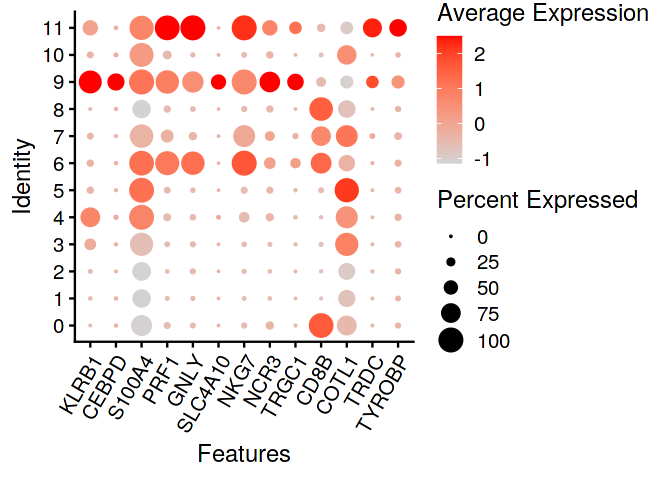

In [129]:
options(repr.plot.width=5.5, repr.plot.height=4)

DotPlot(scRNAsub, features = rev(unique( rownames(rs7_9) )), cols = c("lightgrey", "red") ) +
 theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

### final dot plot

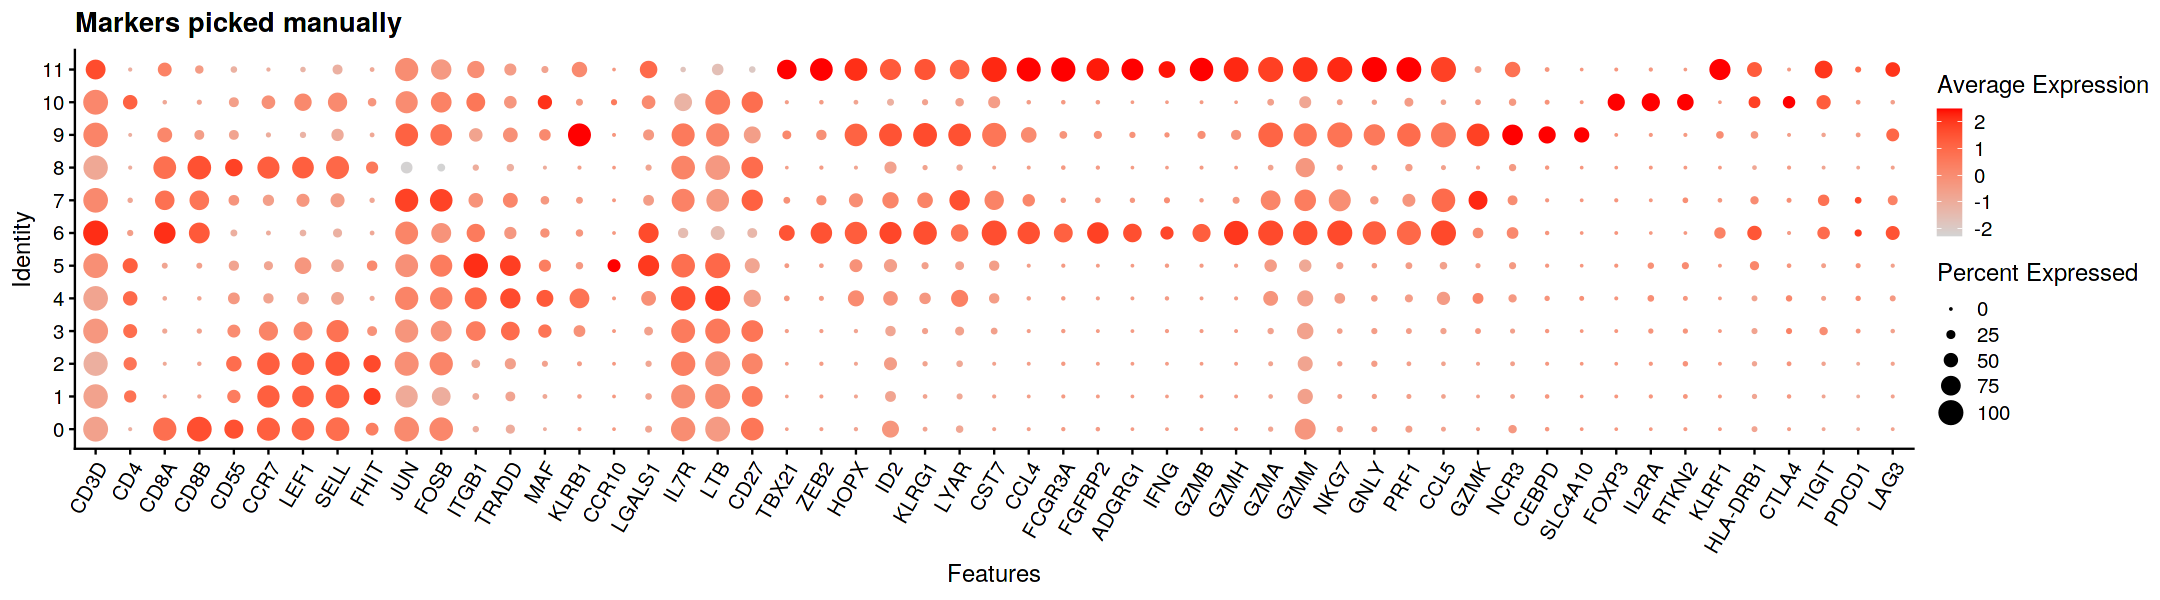

In [191]:
gene.list=c(
    "CD3D",#"CD3E",
    "CD4",         #cd4: 1,2,3,4,5,  11
    "CD8A","CD8B", #CD8: 0,9,  6,8,10,12
    
    "CD55", #"RUNX2", naive CD8
    "CCR7","LEF1","SELL","FHIT", # naive 
    "JUN","FOSB",  # 0 vs 8 "ADGRG1", "CCL4", #11
    "ITGB1", #"S100A4", #"S100A11","CRIP1","KLF6","ANXA1", #  (1,2) vs 3
    "TRADD","MAF", #central memory CD4  ( c5 )
    
    "KLRB1", #4
    "CCR10","LGALS1", #5
   
    "IL7R","LTB", # 6 vs 11
    "CD27", #7
    "TBX21", "ZEB2","HOPX","ID2",#"TOX",# "ZNF683","HIF1A",
    
    "KLRG1", "LYAR","CST7",  #CD4 effector memory ( c4 )"STOM","MYBL1",
    "CCL4", "FCGR3A", #11
    "FGFBP2",  # c6:     EM CD8
    
    "ADGRG1", #11
    "IFNG","GZMB","GZMH","GZMA","GZMM", "NKG7","GNLY","PRF1","CCL5","GZMK",  # toxic  #6 7 9 11
     "NCR3","CEBPD","SLC4A10", #9
    
    "FOXP3", "IL2RA", "RTKN2", # c10: CD4 Treg
    "KLRF1", # c11: EMRA CD8  
    
    "HLA-DRB1", 
    "CTLA4","TIGIT","PDCD1","LAG3" #,inhibitory
)
p1=DotPlot(scRNAsub, features = rev(unique( gene.list )), cols = c("lightgrey", "red") ) +
 theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )+labs(title="Markers picked manually")

options(repr.plot.width=18, repr.plot.height=5)
p1

ggsave(file=paste0(outputRoot,"02_dotPlot_manualMarker.pdf"), p1, width=18, height=5 )

## 细胞命名

In [194]:
cellTypes=(function(){
    rs=data.frame(
        cluster=seq(0,11),
        cellType=c("Naive CD8-0", #0;
    "Naive CD4-1", #1;
    "Naive CD4-2",  #2;
    "Naive CD4-3", #3
                   
    "CD4-KLRB1", #4;
    "CD4-CCR10", #5;
                   
    "CD8-FGFBP2",  #6;
    "CD8-CD27", #7;
                   
    "Naive CD8-8",  #8;
                   
    "CD8-KLRB1", #9 NTK;

    "CD4-Treg", #10;
    "CD8-KLRF1" #11 NKT
      )
    )
    rs$one=paste0(rs$cluster,"-", rs$cellType)
    rs
})()
cellTypes

cluster cellType    one          
1   0      Naive CD8-0 0-Naive CD8-0
2   1      Naive CD4-1 1-Naive CD4-1
3   2      Naive CD4-2 2-Naive CD4-2
4   3      Naive CD4-3 3-Naive CD4-3
5   4      CD4-KLRB1   4-CD4-KLRB1  
6   5      CD4-CCR10   5-CD4-CCR10  
7   6      CD8-FGFBP2  6-CD8-FGFBP2 
8   7      CD8-CD27    7-CD8-CD27   
9   8      Naive CD8-8 8-Naive CD8-8
10  9      CD8-KLRB1   9-CD8-KLRB1  
11 10      CD4-Treg    10-CD4-Treg  
12 11      CD8-KLRF1   11-CD8-KLRF1

In [195]:
new.cluster.ids=as.character(cellTypes$cellType)
names(new.cluster.ids) <- levels(scRNAsub)
new.cluster.ids

0             1             2             3             4 
"Naive CD8-0" "Naive CD4-1" "Naive CD4-2" "Naive CD4-3"   "CD4-KLRB1" 
            5             6             7             8             9 
  "CD4-CCR10"  "CD8-FGFBP2"    "CD8-CD27" "Naive CD8-8"   "CD8-KLRB1" 
           10            11 
   "CD4-Treg"   "CD8-KLRF1"

In [196]:
scRNAsub2 <- RenameIdents(scRNAsub, new.cluster.ids)
levels(scRNAsub2@active.ident)

[1] "Naive CD8-0" "Naive CD4-1" "Naive CD4-2" "Naive CD4-3" "CD4-KLRB1"  
 [6] "CD4-CCR10"   "CD8-FGFBP2"  "CD8-CD27"    "Naive CD8-8" "CD8-KLRB1"  
[11] "CD4-Treg"    "CD8-KLRF1"

In [199]:
scRNAsub2@meta.data$cellType=factor(scRNAsub2@active.ident)
head(scRNAsub2@meta.data)

orig.ident nCount_RNA nFeature_RNA percent.mt RNA_snn_res.0.5
AAACCCAGTCGGTGAA pbmc10k     6590      1867         10.303490  13             
AAACCCATCAGACAAA pbmc10k    11543      2850          6.688036  2              
AAACCCATCCATACTT pbmc10k     6686      2370          9.856416  4              
AAACGAACAACTCGAT pbmc10k     5453      1480         11.424904  2              
AAACGAACACCGAATT pbmc10k    10146      2406          3.617189  1              
AAACGAACAGACACCC pbmc10k     8703      2369          3.171320  3              
                 seurat_clusters cellType    RNA_snn_res.0.9 RNA_snn_res.1
AAACCCAGTCGGTGAA 9               CD8-KLRB1   9               9            
AAACCCATCAGACAAA 0               Naive CD8-0 0               0            
AAACCCATCCATACTT 6               CD8-FGFBP2  5               6            
AAACGAACAACTCGAT 8               Naive CD8-8 8               8            
AAACGAACACCGAATT 2               Naive CD4-2 3               2            
AAACGAACAGACACCC 3               Naive CD4-3 4               3

png 
  2

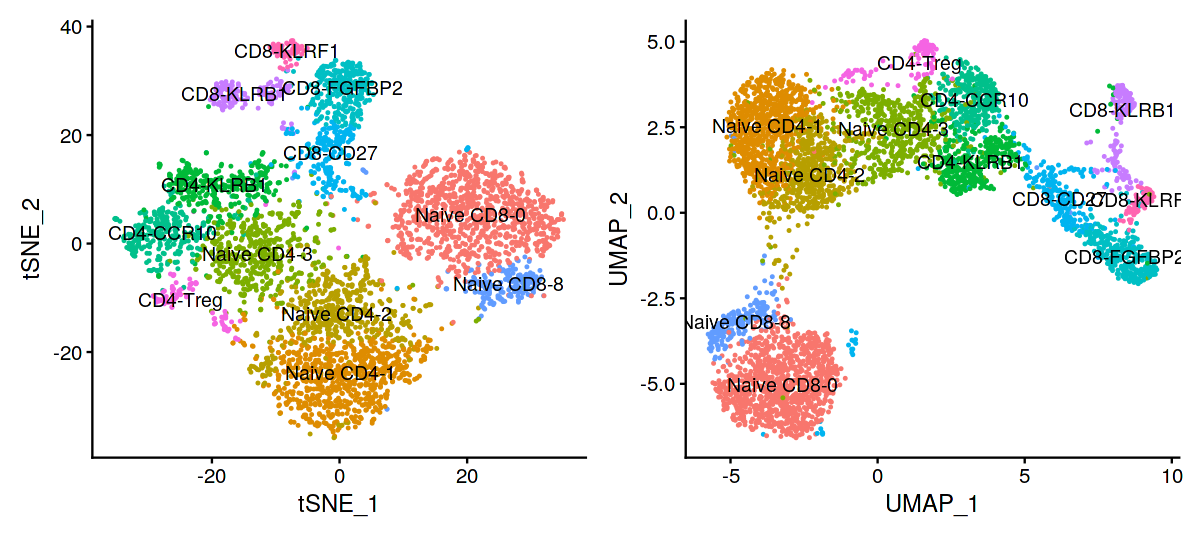

In [202]:
p1=DimPlot(scRNAsub2, reduction = 'tsne', label = T) + NoLegend()
p2=DimPlot(scRNAsub2, reduction = 'umap', label = T) + NoLegend()
pc=p1+p2

options(repr.plot.width=10, repr.plot.height=4.5)
pc


pdf( paste0(outputRoot, "04_plot_tSNE-withCellName.pdf"), width=10, height=4.5)
print(pc)
dev.off()

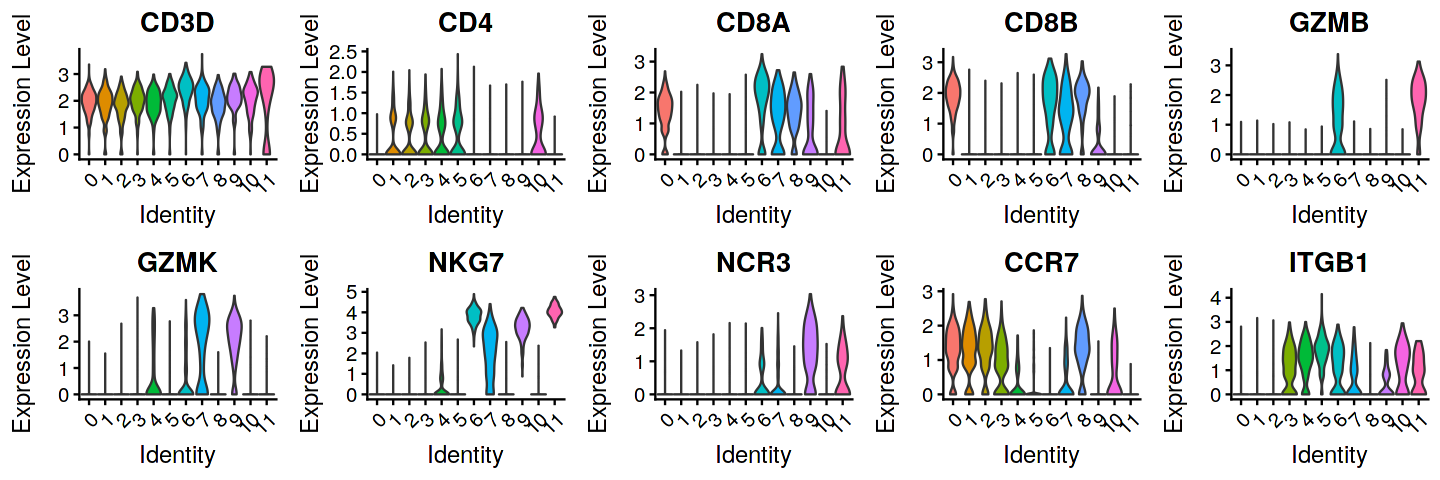

In [204]:
options(repr.plot.width=12, repr.plot.height=4)

VlnPlot(scRNAsub2, features = c("CD3D","CD4", "CD8A","CD8B", "GZMB", "GZMK", "NKG7","NCR3", "CCR7", "ITGB1"), 
        ncol = 5, pt.size=0, group.by = "seurat_clusters")

### save

In [203]:
saveRDS(scRNAsub2, file = paste0(outputRoot,"pbmc10k-Tsubset_final.rds") ) #long time: 2min